In [1]:
import napari
import napari_stress
import napari_process_points_and_surfaces as nppas
import vedo
import tqdm

from skimage import io, filters
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# create viewer
viewer = napari.Viewer(ndisplay=3)

In [3]:
directory = r'E:\BiAPoL\Shared\BiAPoLprojects\20_STRESS\1_first_data'
raw = io.imread(os.path.join(directory, 'ExampleTifSequence-InteriorLabel_sub.tif'))
n_frames = raw.shape[0]

## Parameters

The analysis requires some parameters to be set. This is what they do and the influence they have:

* `vsz`, `vsy`, `vsy`: Voxel sizes in z, y and x. Necessary to shape the data into isotropic voxel sizes
* `surface_density`: This  controls how many points will constitute the surface further down. Lower number will lead to a rough surface approximation and possibly faulty surface tracing results. Higher values lead to a smoother surface, but longer computation times.
* `curvature_radius`: Radius in microns for curvature calculation. Points within this radius around a specified vertex will be taken into account for the curvvature calculation. Larger radii will lead to the curvature being represented on a more global scale, smaller radii will lead to a more localized curvature measure.
* `n_iterations_refinement`: The surface refinement procedure will be conducted multiple times. Higher values lead to a smoother surface and higher computation times.


In [4]:
# Config
vsz = 3.998
vsy = 2.076
vsx = 2.076

surface_density = 0.5
curvature_radius = 5
n_iterations_refinement = 3

In [5]:
viewer.add_image(raw, scale=[vsz, vsy, vsx], name='Raw data')

<Image layer 'Raw data' at 0x1fb59c2e670>

## Preprocess

We first resample the image to isotropic voxel size and create a binary mask

In [6]:
# Resample
resampled_image = []
for t in range(n_frames):
    resampled_image.append(napari_stress.resample(raw[t], vsz=vsz, vsy=vsy, vsx=vsx))
resampled_image = np.asarray(resampled_image)
viewer.add_image(resampled_image, scale = 3 * [np.min([vsz, vsy, vsx])])

<Image layer 'resampled_image' at 0x1fb506a16a0>

In [7]:
# Masking
binary_image = resampled_image > filters.threshold_otsu(resampled_image)
binary_image_layer = viewer.add_labels(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])

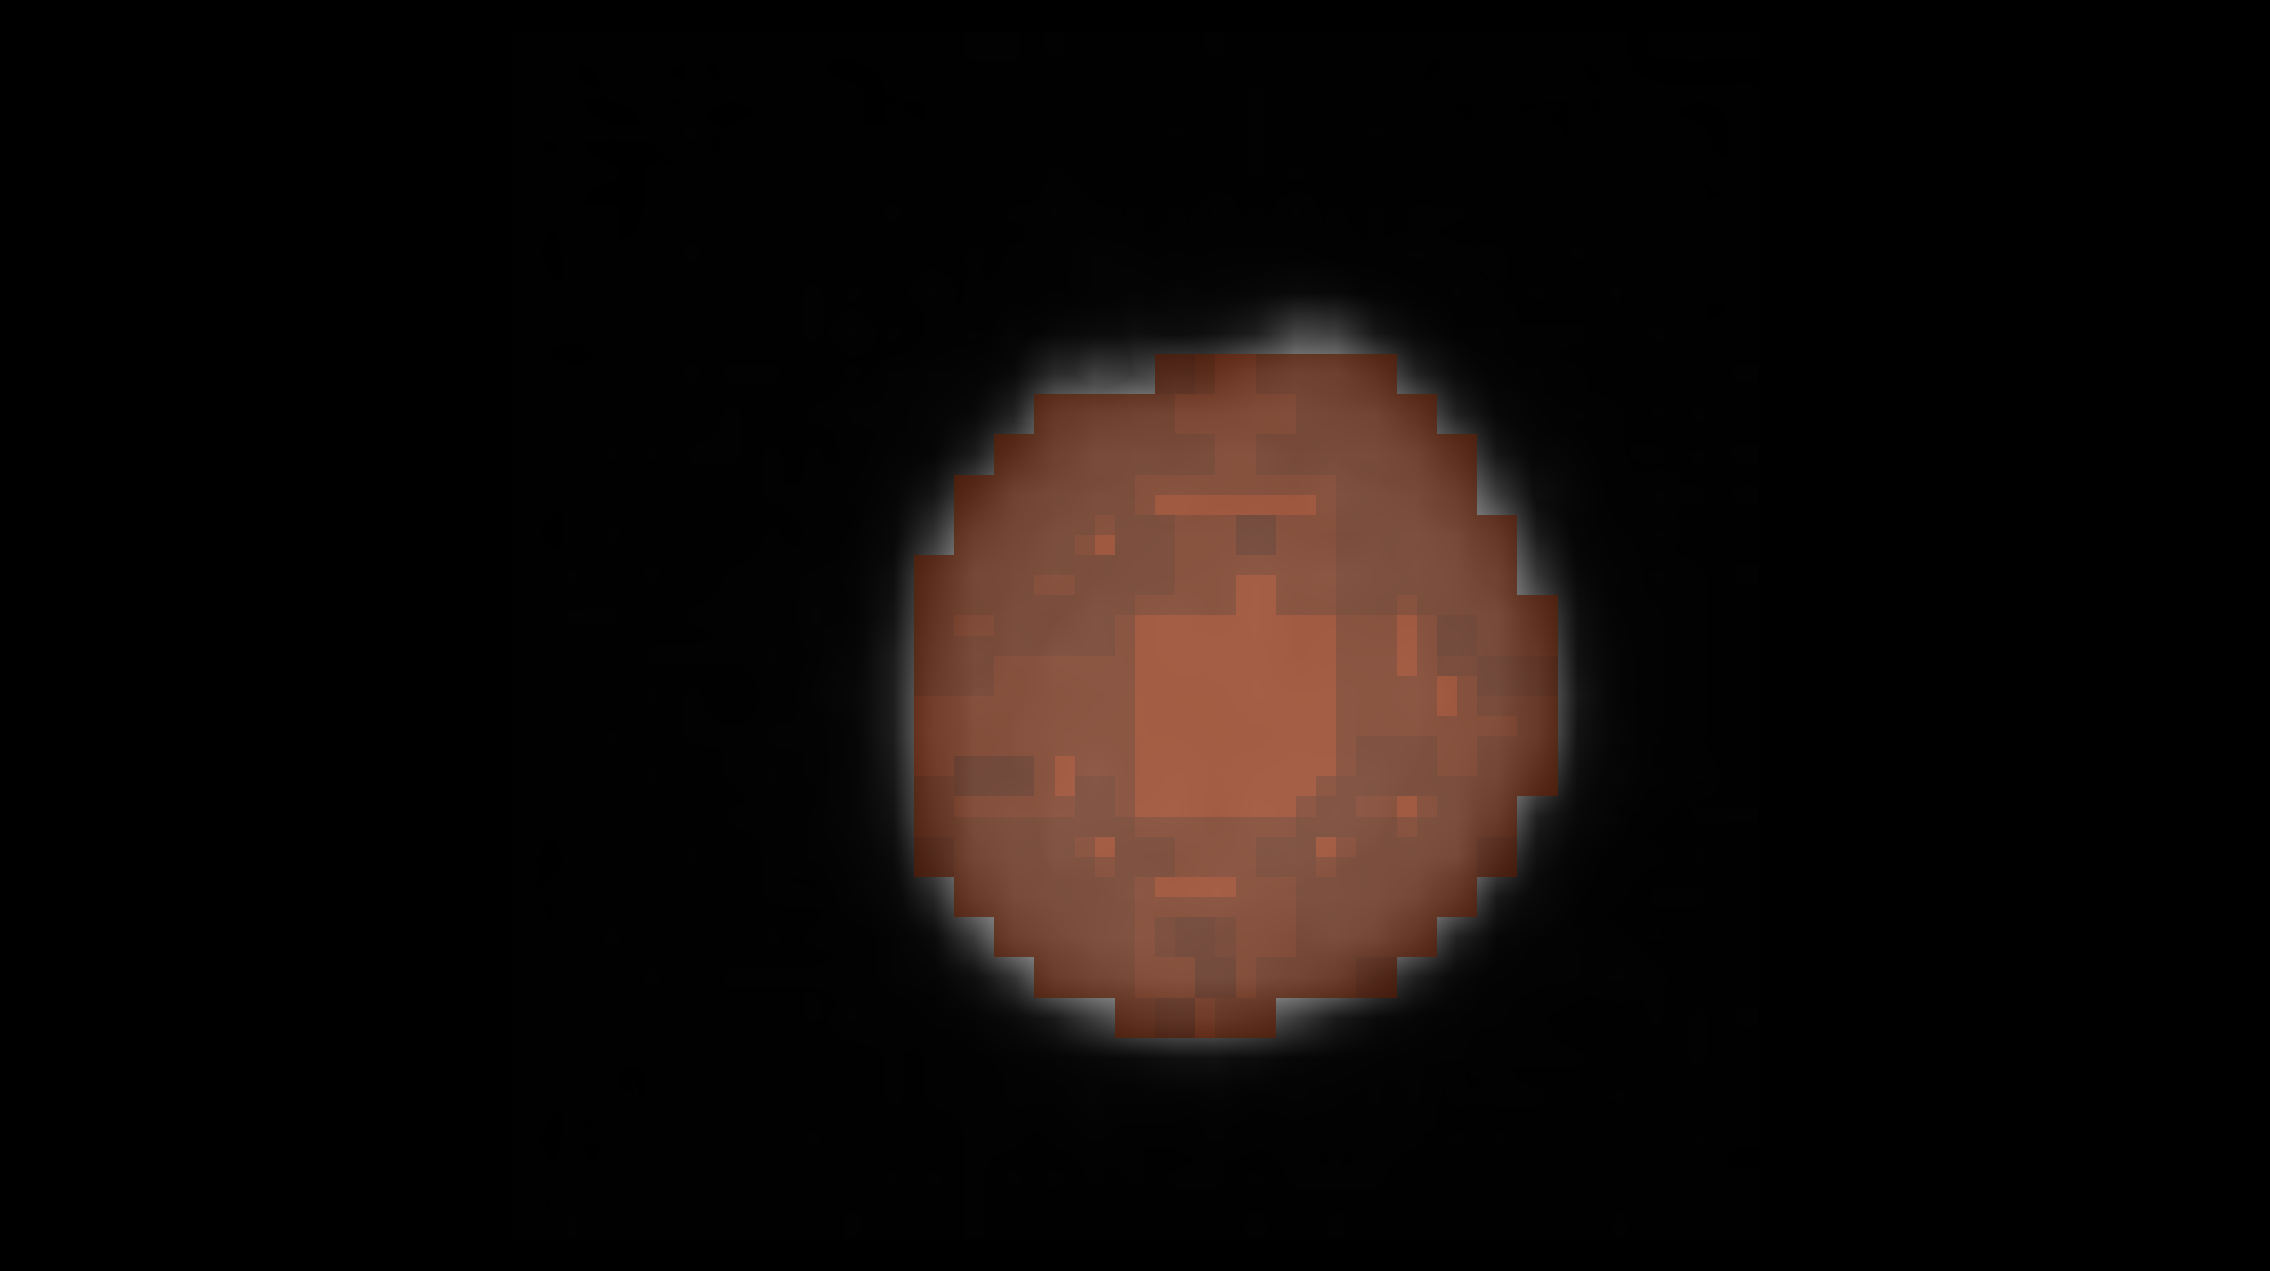

In [8]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Create surface

We use the marching cubes algorithm to create a surface from the binary image. We then smooth the surface a bit.

In [9]:
# Create surface
surface = napari_stress.surface_from_label(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])
surface_layer = viewer.add_surface(surface)

In [10]:
smoothed_surface = napari_stress.frame_by_frame(nppas.filter_smooth_simple)(surface, number_of_iterations=1)
smoothed_surface = napari_stress.frame_by_frame(nppas.fill_holes)(smoothed_surface)
smoothed_surface_layer = viewer.add_surface(smoothed_surface, name='Smoothed surface')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


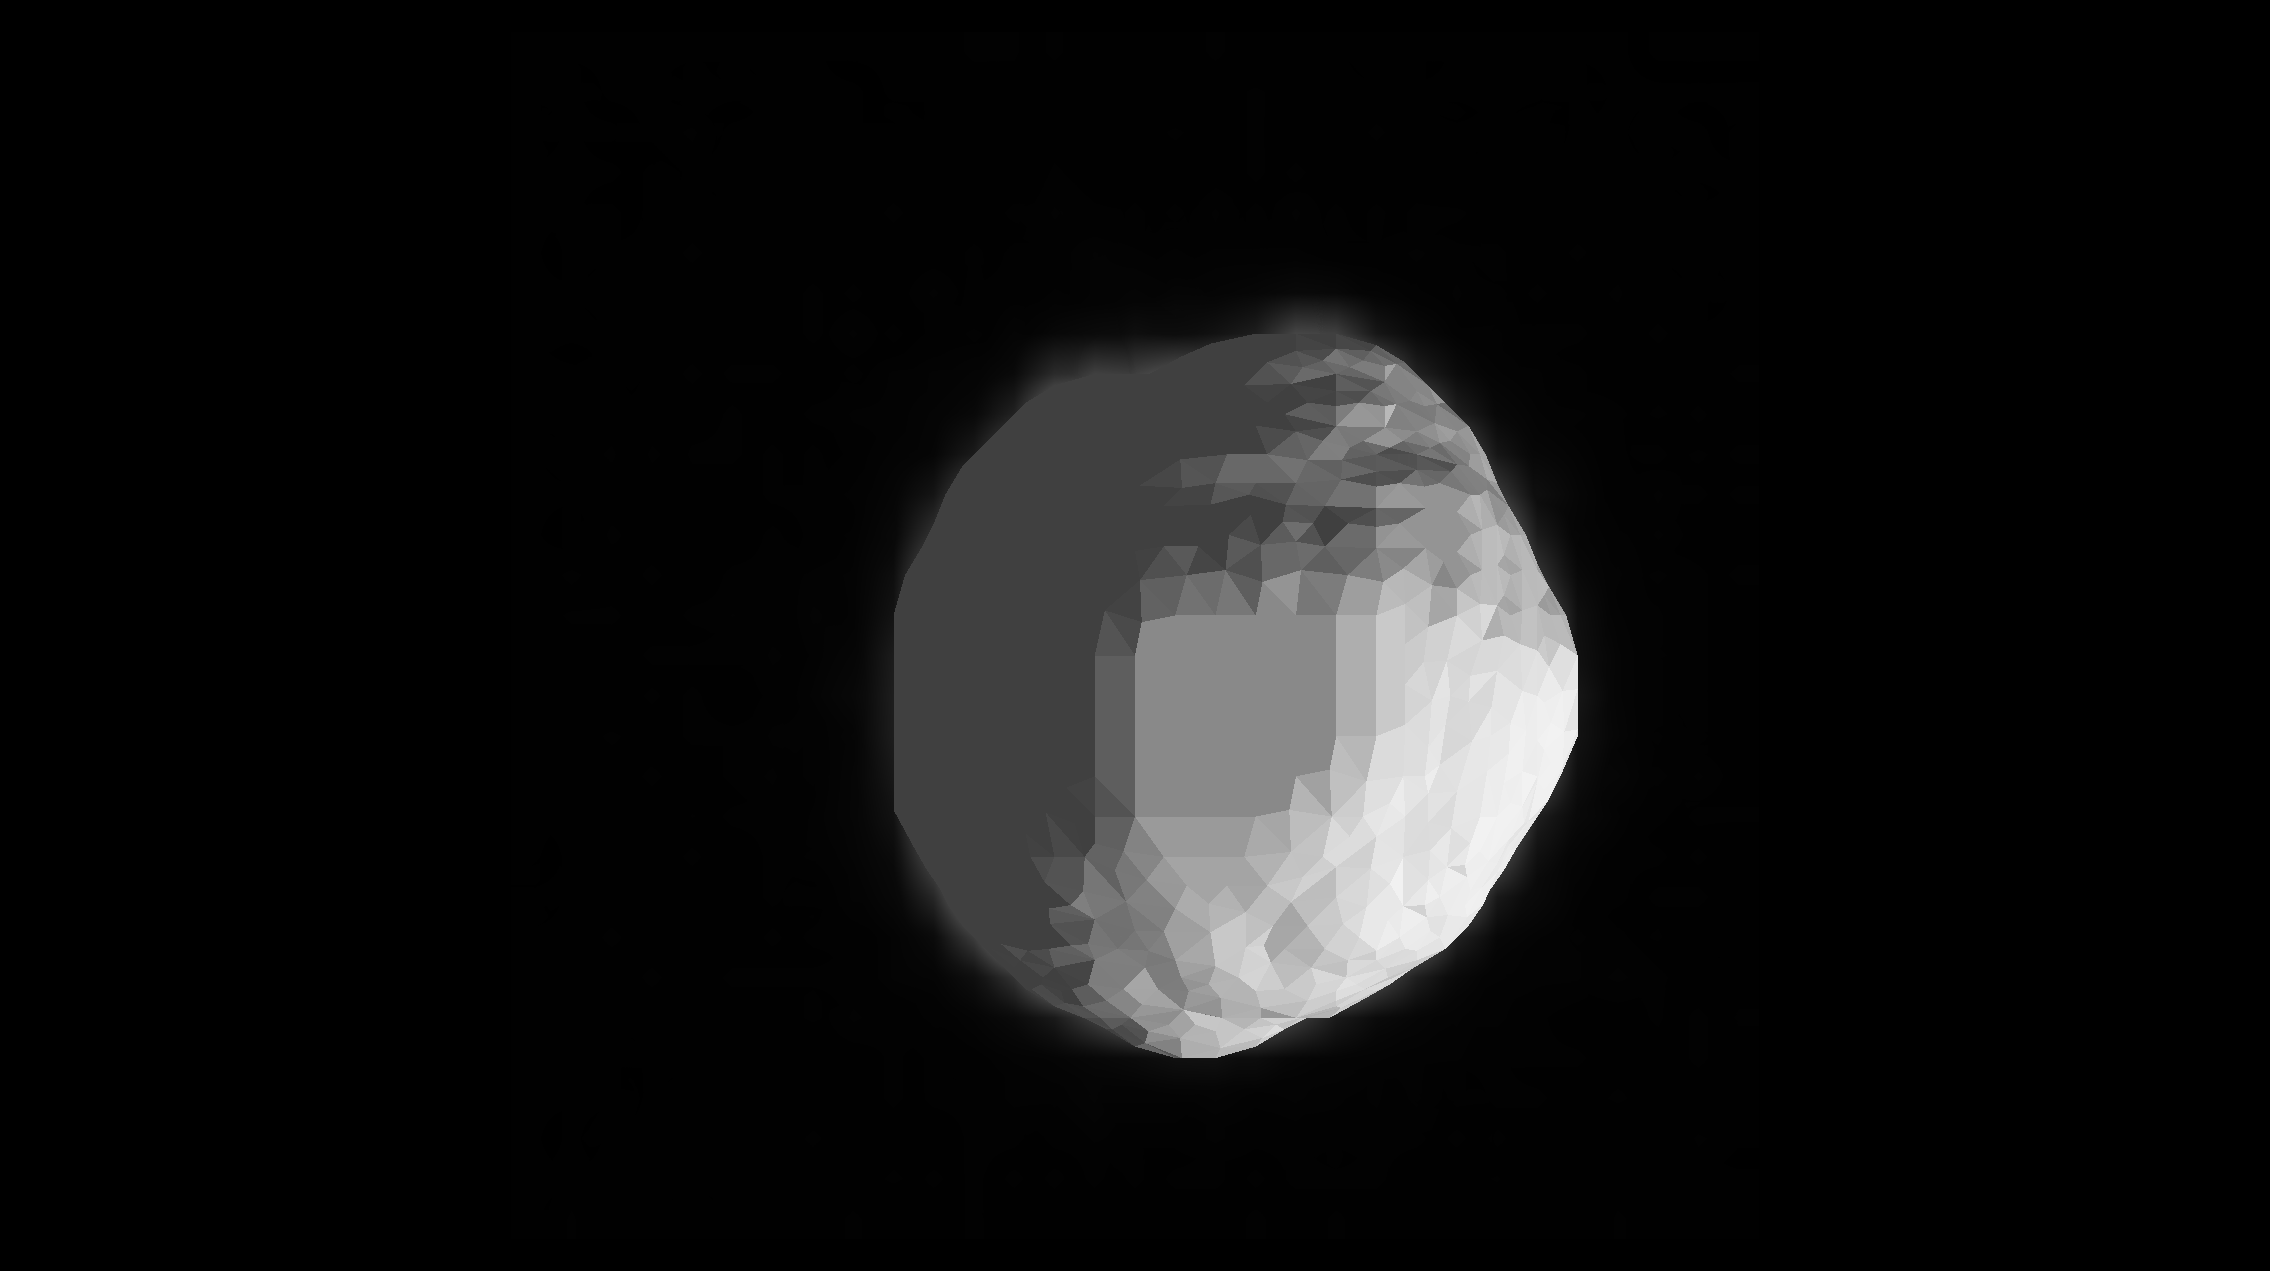

In [11]:
binary_image_layer.visible = False
surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Surface refinement

In the next step, we will trace-refine the surface, filter the detected points and resample the density of the vertices on the surface to a defined value. In detail:

* Resampling: If the numbers of vertices is above the required number of points for a given surface density, then the surface mesh is decimated to achieve the desired vertex density. If the mesh contains less points than desired, the mesh is interpolated and decimated again, if necessary.
* Trace refinement: Rays are cast along the surface normals at every point. A selected edge detection method is then used to detect the surface of the droplet
* Filtering: The edge-detection method returns an error. Points with fit errors above Q75 + 1.5 x IQR (Q75: 75% percentile, ICQ: inter-quartil range) are classified as outliers and removed from the list of points
* Surface reconstruction: Lastly, we recreate a surface from the remaining points and resample the existing points on the surface to fill possible holes.

In [12]:
# Surface resampling
adjusted_surface = napari_stress.adjust_surface_density(smoothed_surface, density_target=surface_density)

density_adjusted_surface_layer = viewer.add_surface(adjusted_surface, name='density-adjusted surface')
density_adjusted_points_layer = viewer.add_points(adjusted_surface[0], size=0.2, name='density-adjusted points')

In [13]:
print('Number of vertices before adjustment:', smoothed_surface[0].shape[0])
print('Number of vertices after adjustment:', adjusted_surface[0].shape[0])

Number of vertices before adjustment: 2488
Number of vertices after adjustment: 3899


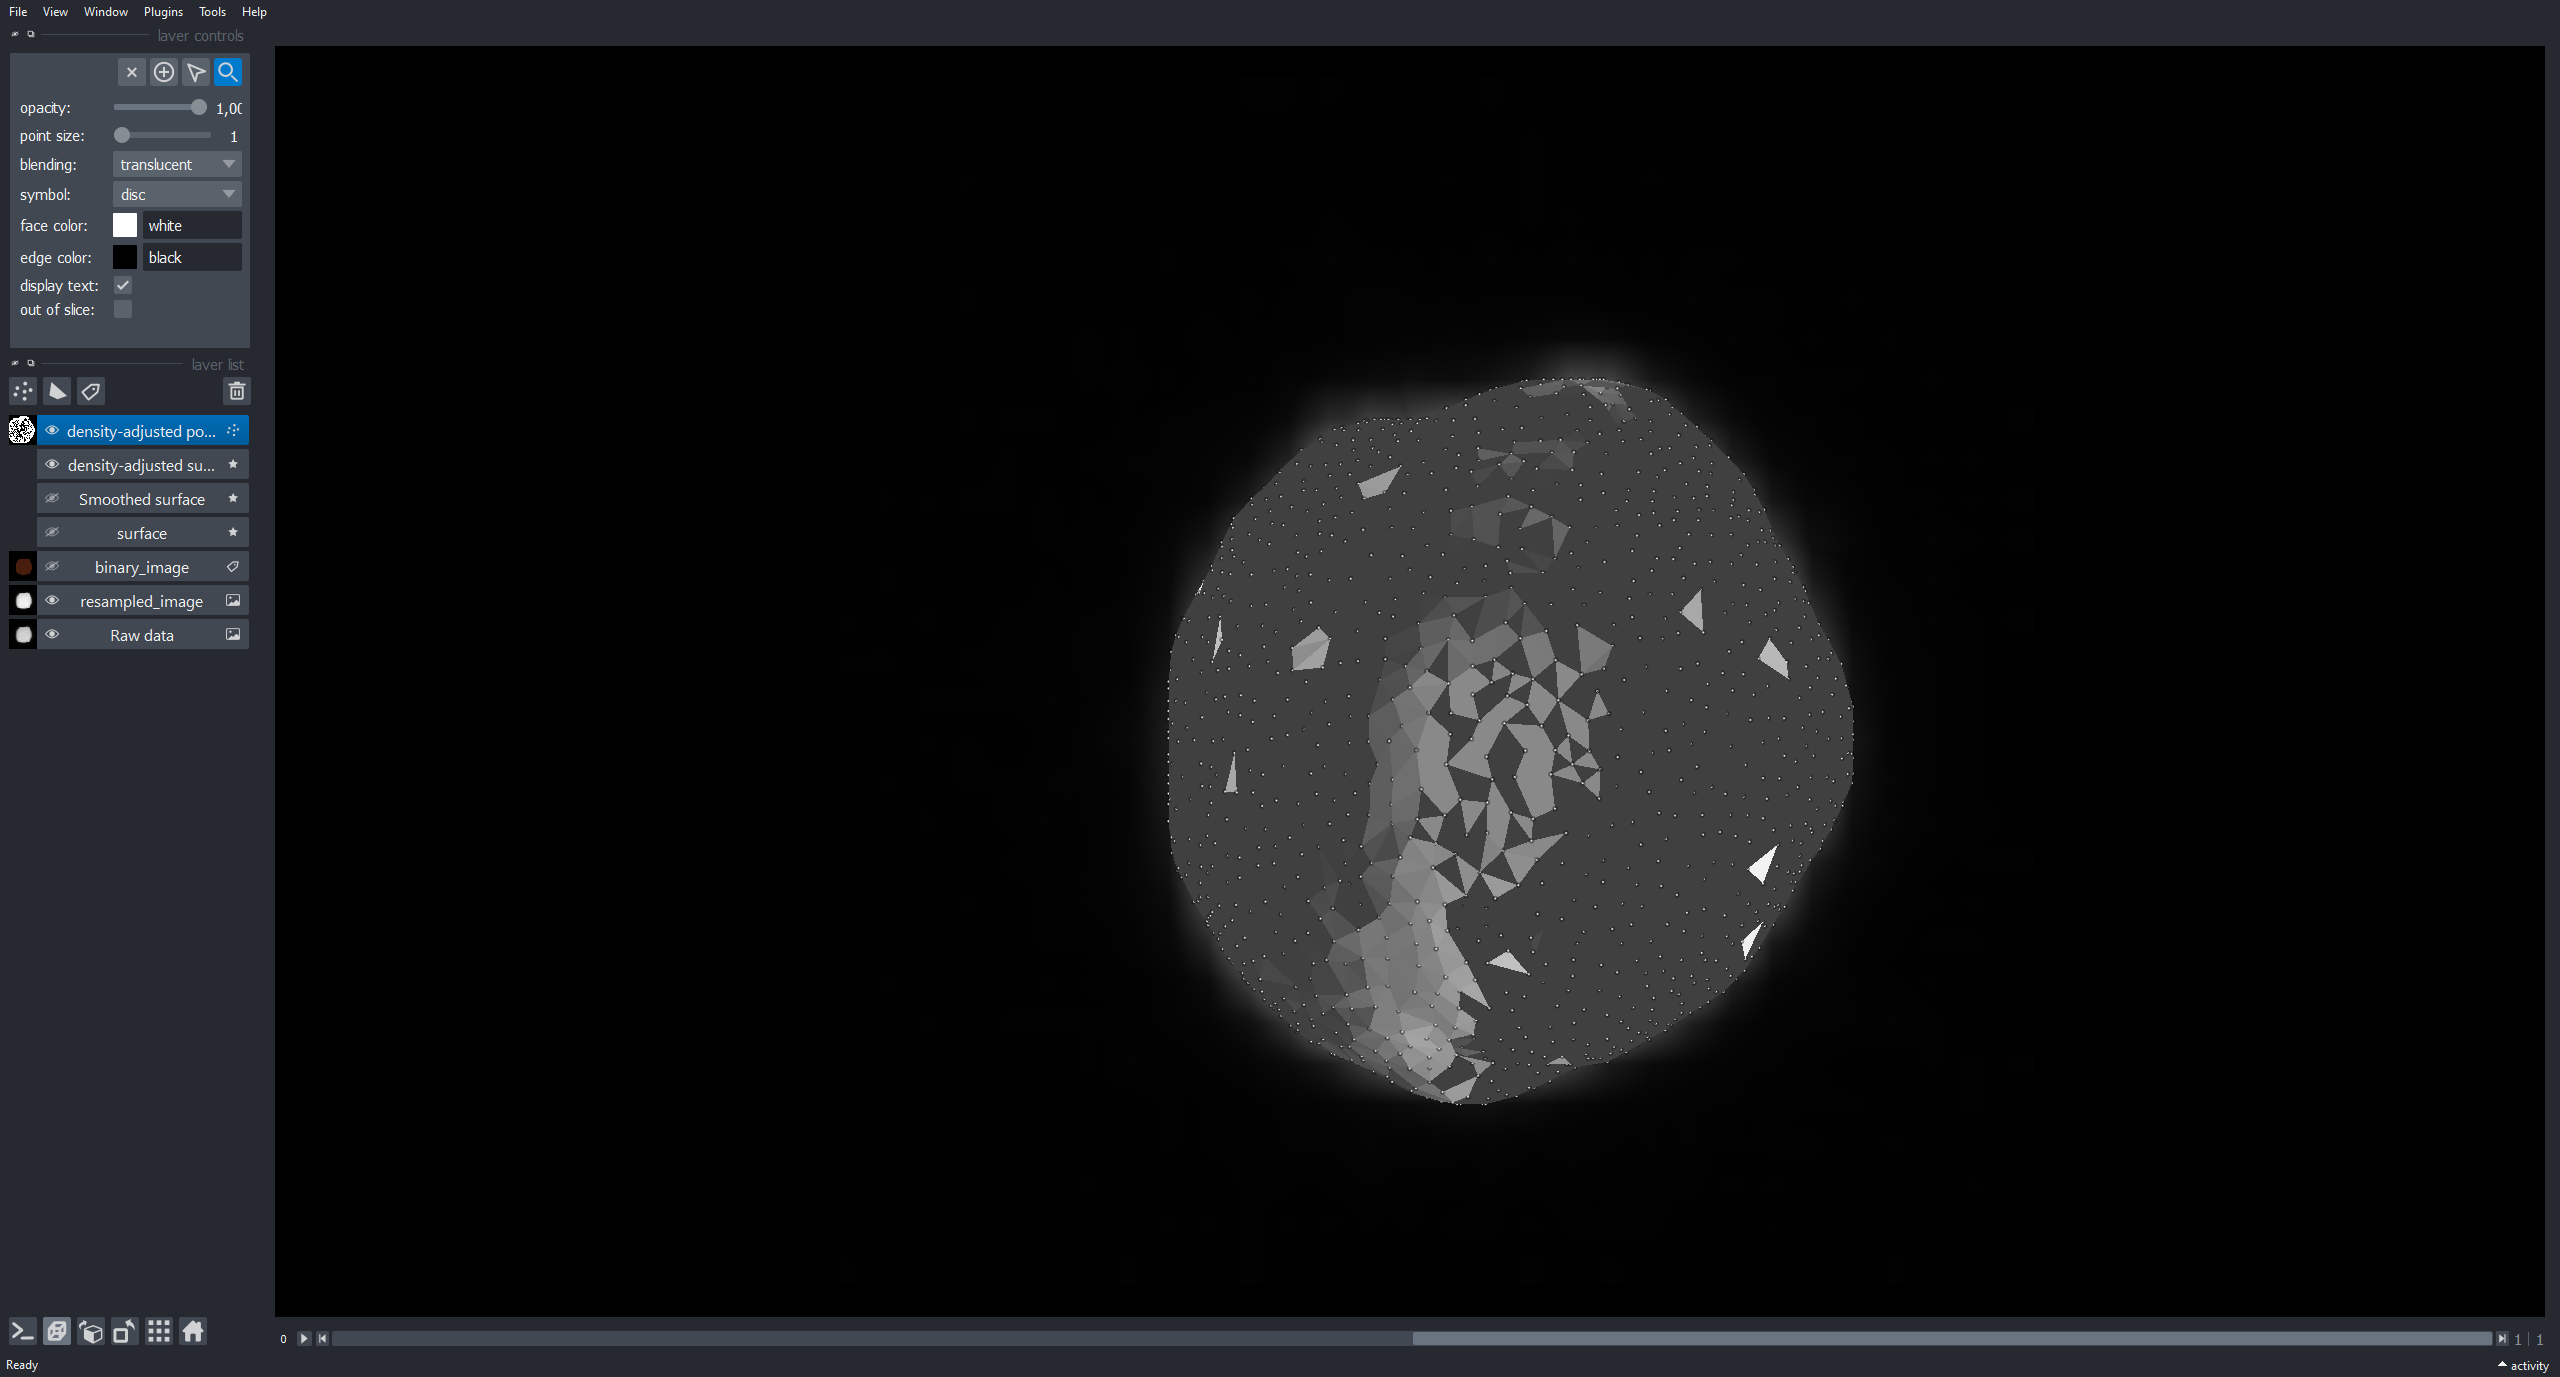

In [14]:
smoothed_surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=False)

In this step we perform the *trace-refinement* of the surface. For this, the surface normal vector is calculated at every vertex of the surface and the innstensity of the resampled intensity image is interpolated along the trace vector. A sigmoidal curve model is then fitted to the intensity profile to determine the exact location of the droplet's boundary. Depending on the fit parameters and the residual errors, points with excessively high fit errors can directly be removed from the surface.

Parameters to consider for this process:

* `trace_length`: The normal vector is normalized to length 1, but it makes sense to take a trace vector that is longer to capture the intensity profile across the droplets's border. The length of thhis vector can be controlled with this parameter.
* `sampling_distance`: Distance between interpolated points along the trace vector. Should generally be < `trace_length/10`.
* scale: scale conversion factor to convert between point coordinates and voxel coordinates in the intensity image. Corresponds to the above-set `vsx`, `vsy` and `vsz`.
* `show_progress`: Show a progress bar for all the traces to be fitted.
* `selected_fit_type`: Can be `'fancy'` or `'quick'` - `'fancy'` is more precise (sub-voxel precision), but slower. `'quick'` is fast, yet limited to voxel-resolution.
* 'remove_outliers': Whether or not to remove outliers based on fit errors from the determined surface points. Can be `True` or `False`.
* `interquartile_factor`: Points are classified as outliers if the fit error exceeds `Q75 + interquartile_factor * IQD` with Q75 being the 75%-percentile of the fit errors and IQD being the interquartile distance (i.e., Q75 - Q25).

In [18]:
resampled_points = adjusted_surface[0]  # get points from density-adjusted surface

for i in range(n_iterations_refinement):
    traced_points = napari_stress.trace_refinement_of_surface(resampled_image,
                                                              resampled_points,
                                                              trace_length=20.0, sampling_distance=1,
                                                              scale=binary_image_layer.scale[1:],
                                                              show_progress=True,
                                                              selected_fit_type='fancy',
                                                              remove_outliers=True,
                                                              interquartile_factor=1.5)
    print('Number of faulty vertices: ', resampled_points.shape[0] - traced_points.shape[0])
    resampled_points = napari_stress.resample_points(traced_points)
    
traced_pts_layer = viewer.add_points(resampled_points, face_color='orange', size=1.0, name='Traced points')


Processing vertices...: 100%|█████████████████████████████████████████████████████| 1946/1946 [00:07<00:00, 251.42it/s]


Number of faulty vertices:  285


Processing vertices...: 100%|█████████████████████████████████████████████████████| 1796/1796 [00:06<00:00, 298.30it/s]


Number of faulty vertices:  230


Processing vertices...: 100%|█████████████████████████████████████████████████████| 1677/1677 [00:05<00:00, 301.51it/s]


Number of faulty vertices:  180


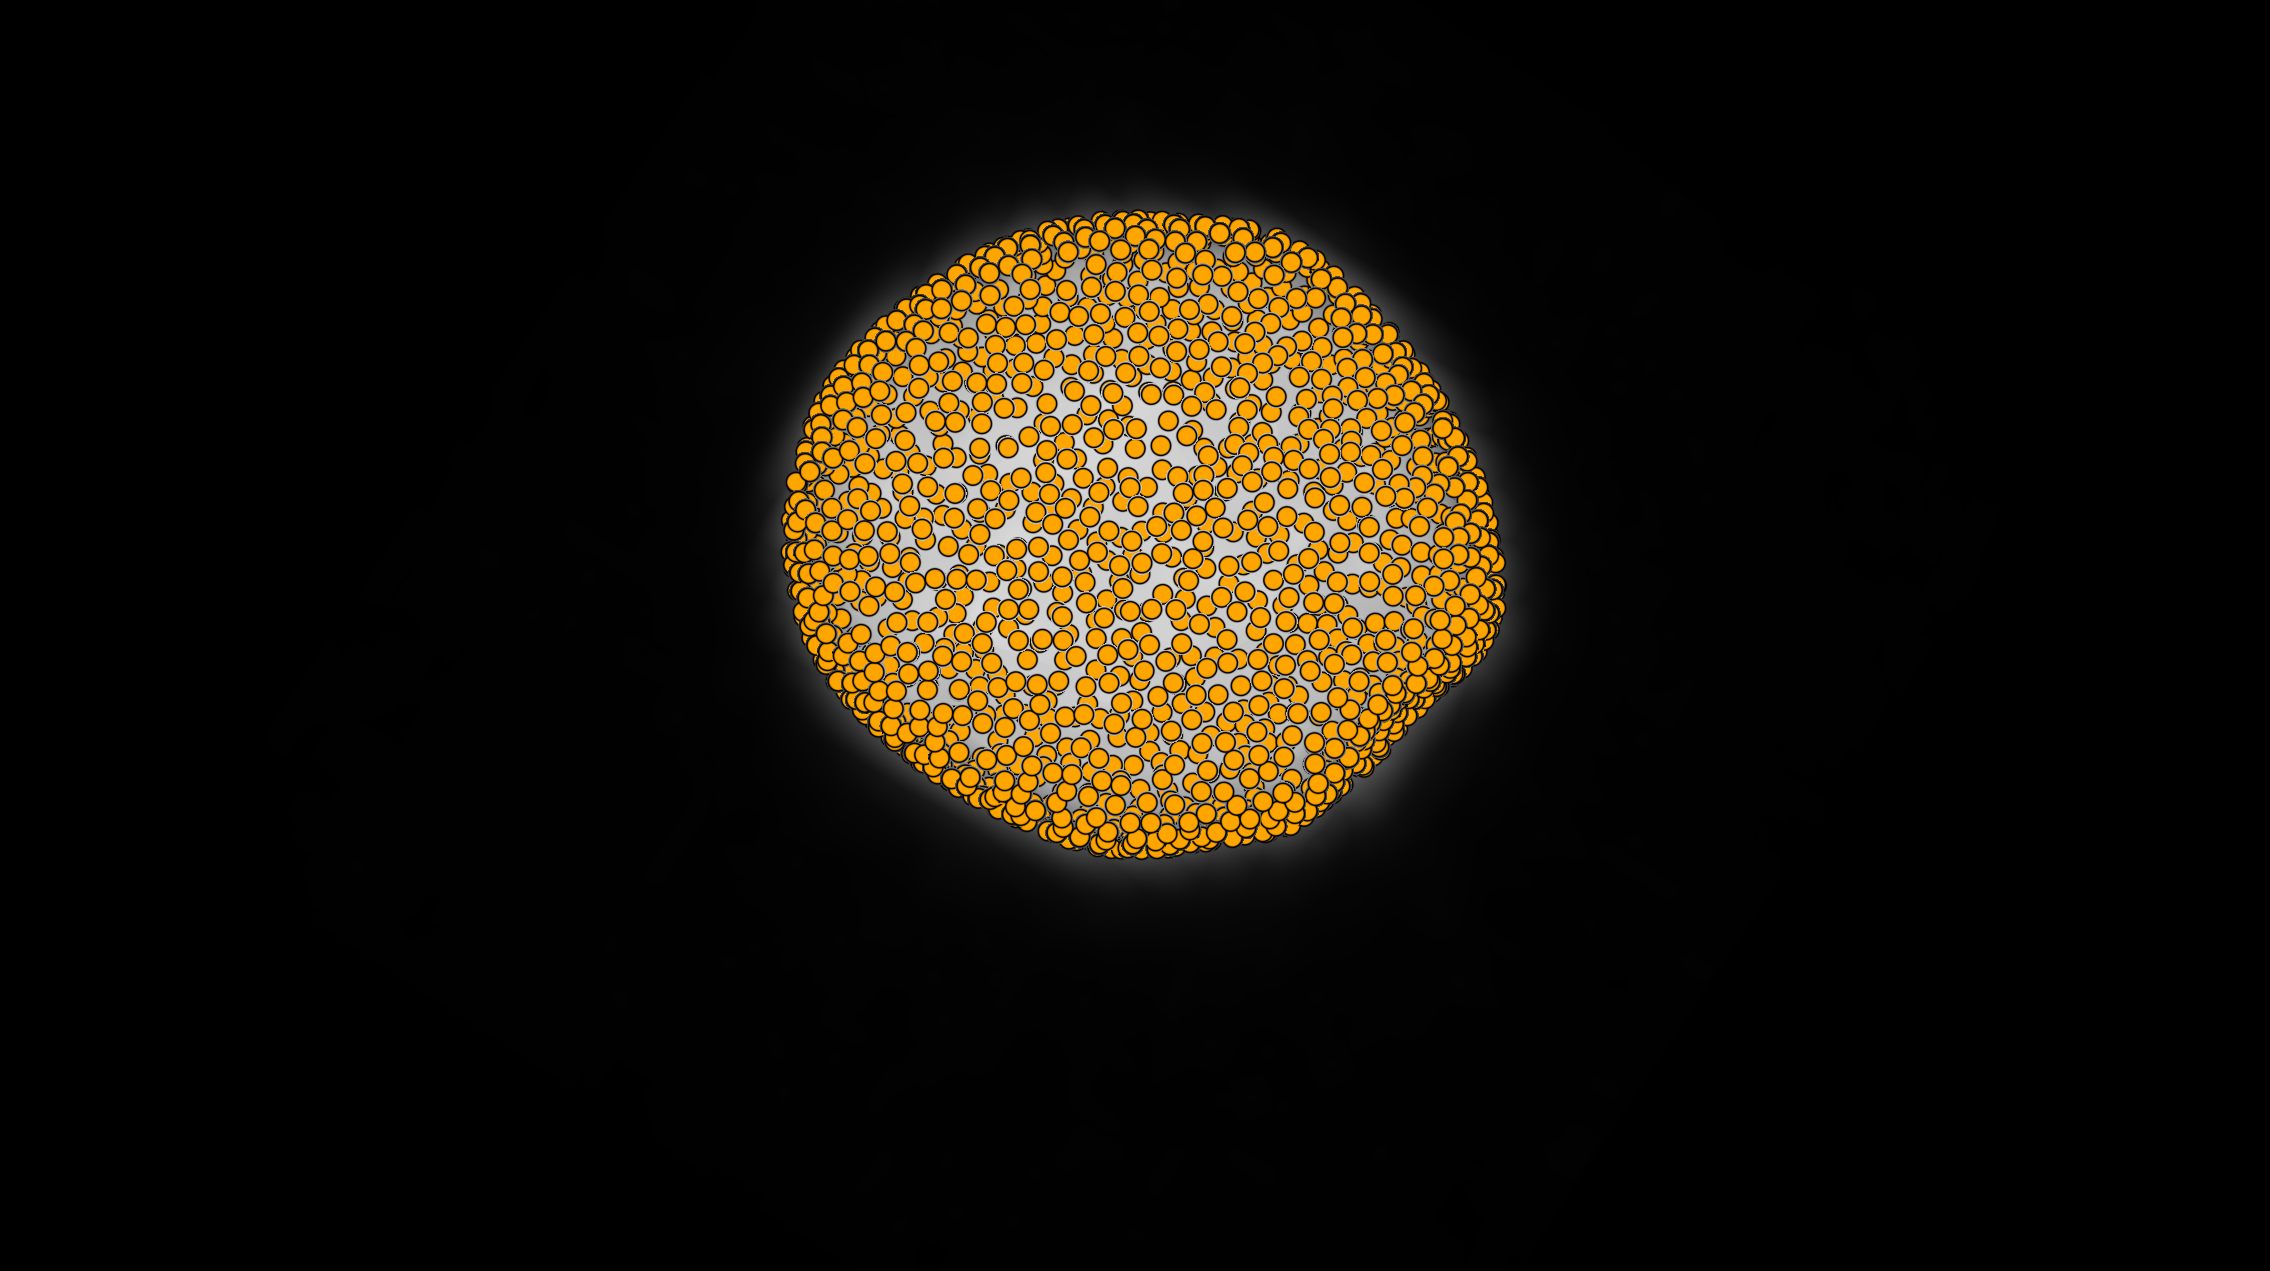

In [19]:
smoothed_surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)

The result of the point fitting is a point cloud which needs to be converted back into a surface for better visualization of curvatures.

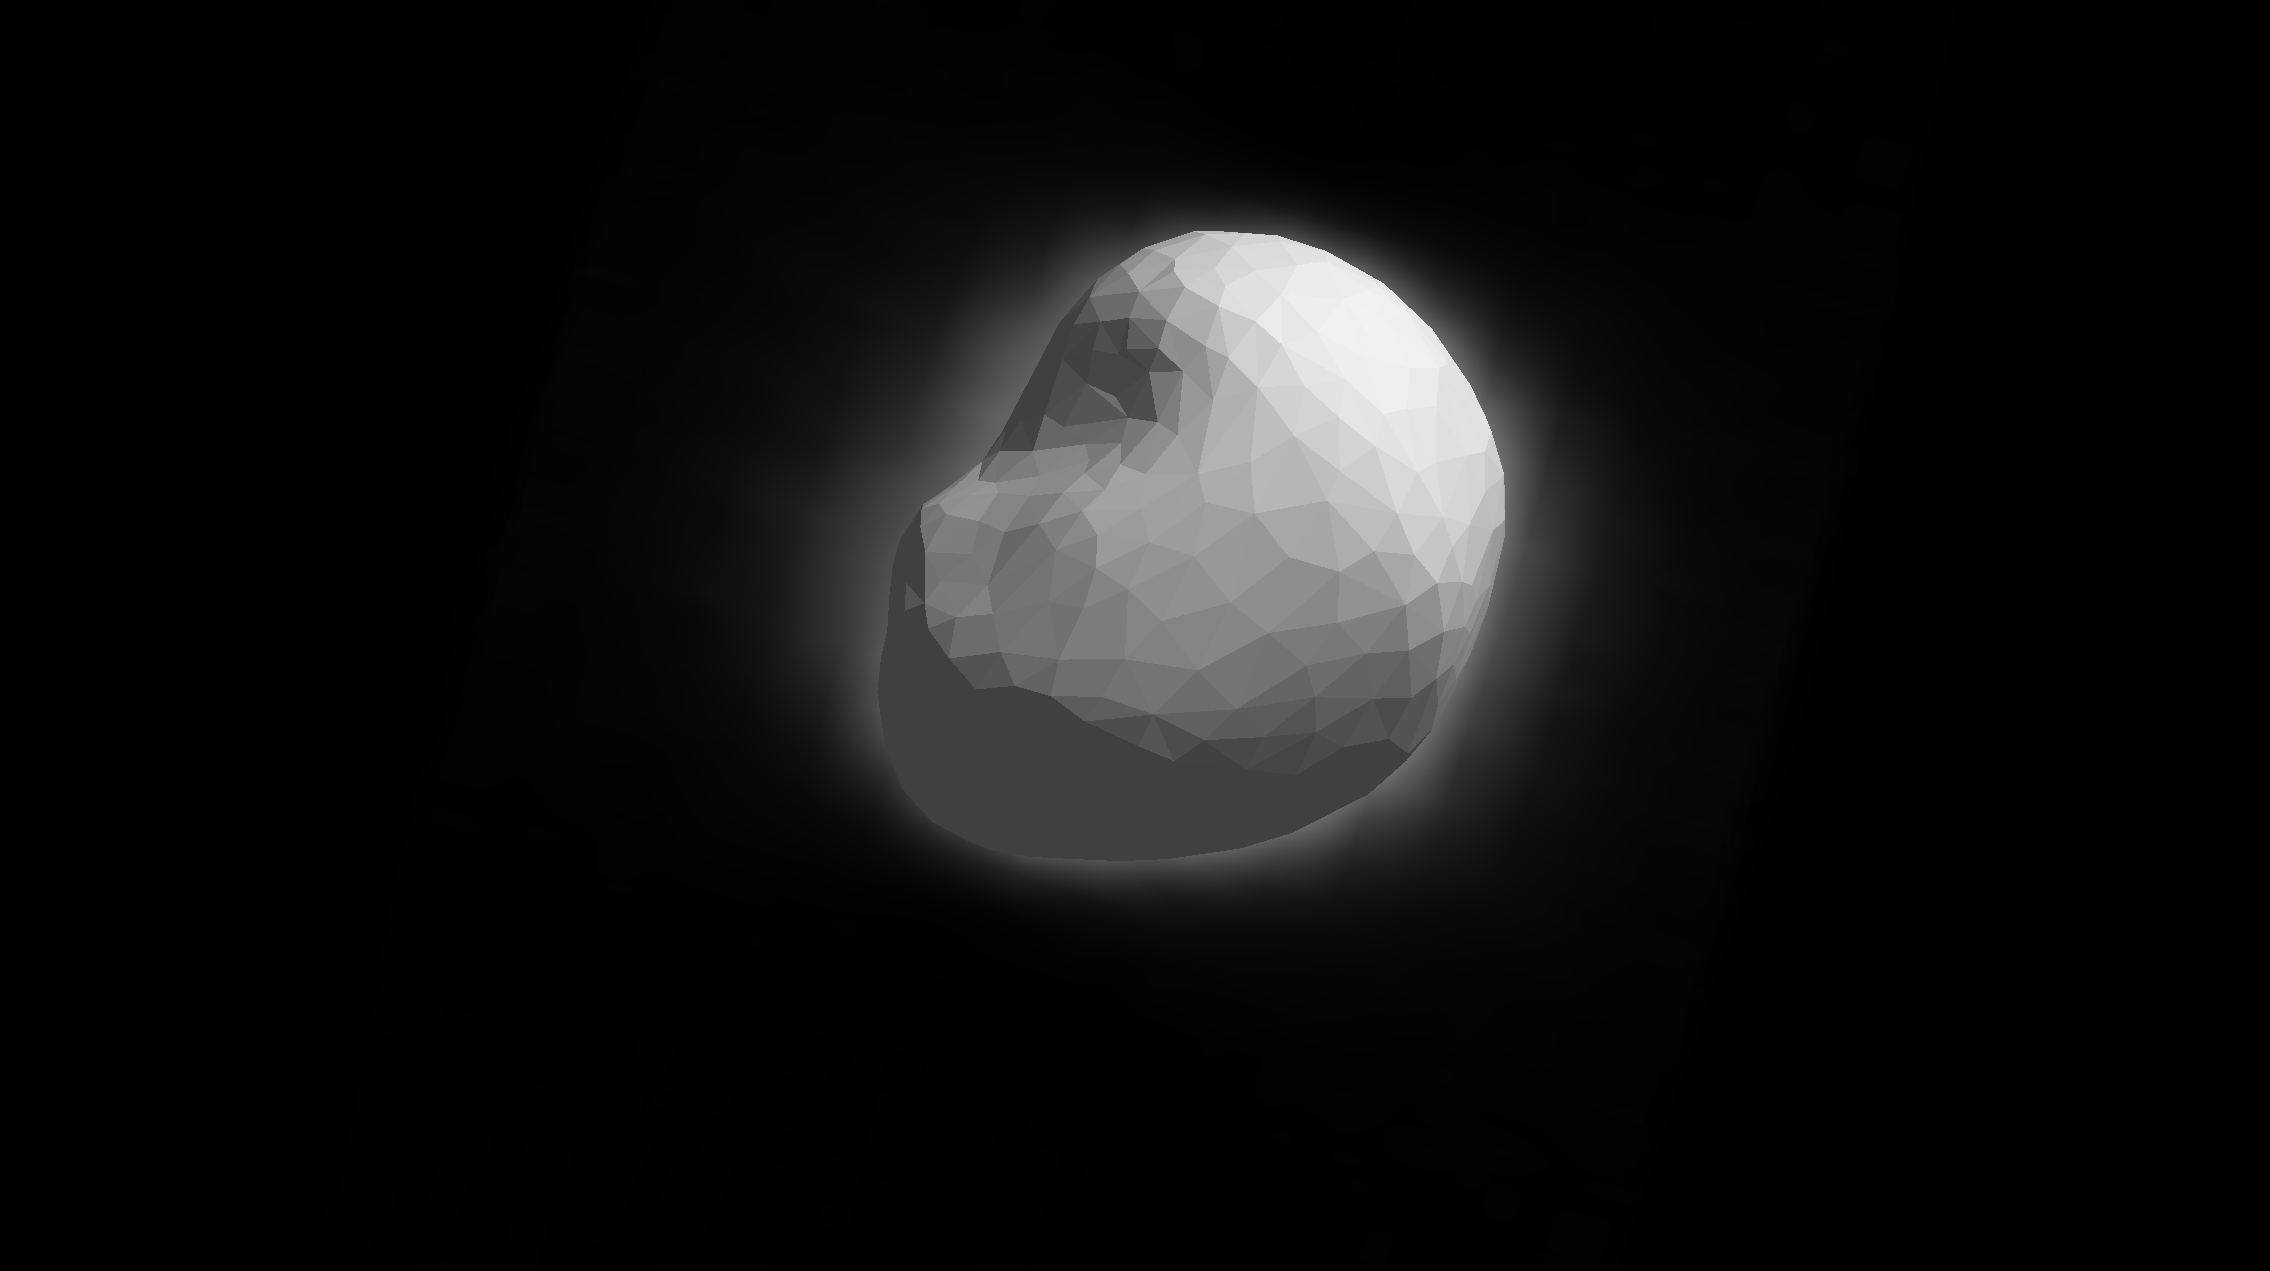

In [21]:
# Surface reconstruction
traced_surface = napari_stress.reconstruct_surface(resampled_points)
traced_surface = napari_stress.frame_by_frame(nppas.simplify_quadric_decimation)(traced_surface, target_number_of_triangles=1000)
viewer.add_surface(traced_surface)
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Curvature

Lastly, we measure the curvature of the object and encode its value in the surface color:

In [22]:
napari_stress.frame_by_frame(nppas.add_spherefitted_curvature, progress_bar=True)(traced_surface, radius=curvature_radius)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:55<00:00, 207.77s/it]


KeyError: typing.List[LayerDataTuple]

In [ ]:
# Visualize curvature
trace_fitted_surface_layer.visible = False
curvature_layer = viewer.add_surface((curvatures[0], curvatures[1], curvatures[2]),
                                     name='Curvature', colormap='viridis',
                                     contrast_limits = [np.quantile(curvatures[2], 0.2), np.quantile(curvatures[2], 0.7)])
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [ ]:
# Visualize fit residues
fit_residue_layer = viewer.add_surface((fit_residues[0], fit_residues[1], fit_residues[2]), name='Fit residues', colormap='inferno')
curvature_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)